## Importing Necessary Libraries and Dependencies
----

In [1]:
# Importing essential libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns             ## New library
import folium                     ## New library

# Filter warnings
import warnings 
warnings.filterwarnings('ignore')



## Loading the Data
---

### Load the waterAir dataset from CSV file

In [2]:
# Load the water dataset from CSV file
waterAir_info_df = pd.read_csv('data/Cities1.csv')
waterAir_info_df.head()

,City,Region,Country,AirQuality,WaterPollution
0,New York,New York,United States of America,46.816038,49.504950
1,Washington,District of Columbia,United States of America,66.129032,49.107143
2,San Francisco,California,United States of America,60.514019,43.000000
3,Berlin,NaN,Germany,62.364130,28.612717
4,Los Angeles,California,United States of America,36.621622,61.299435


### Load the census dataset from CSV file

In [3]:
# Load the census dataset from CSV file
census_info = pd.read_csv('data/us2021census.csv')
census_info.head()

,City,State,Type,Counties,Population,Latitude,Longitude
0,New York,NY,City,Bronx;Richmond;New York;Kings;Queens,8804190,40.714,-74.007
1,Los Angeles,CA,City,Los Angeles,3898747,34.052,-118.243
2,Chicago,IL,City,Cook;DuPage,2746388,41.882,-87.628
3,Houston,TX,City,Harris;Fort Bend;Montgomery,2304580,29.760,-95.363
4,Phoenix,AZ,City,Maricopa,1608139,33.448,-112.074


## Data Processing:
---

#### Before merging the data, the following adjustments were necessary:
1. Select Only the United States: Filter the data to include only entries from the United States.
2. Create a Dictionary of State Abbreviations: Develop a dictionary containing the descriptive names of states and their abbreviations.
3. Add a New Column for State Abbreviations: Create a new column in the `waterAir dataframe` to insert state abbreviations. This step is crucial for accurately comparing cities and states across datasets and performing a more precise merge.
4. Find and Remove Duplicate from Census dataframe: This step is important to ensure that each entry in the dataset is unique.
5. Create the normalize_city_name Function: Implement a function to normalize city names so that all cities are formatted consistently.
6. Analyze Unmatched Data: Investigate any data that did not match and check for potential KeyError issues.
7. Remove Null Values: Eliminate any null values from the datasets to ensure data integrity.
8. Remove Columns with Duplicate or Unused Data: Eliminate columns that contain duplicate information or data that will not be used in the project.

In [4]:
# Filter the data to include only entries from the United States
waterAir_usa_df = waterAir_info_df[(waterAir_info_df['Country'] == 'United States of America')]
waterAir_usa_df.head()

,City,Region,Country,AirQuality,WaterPollution
0,New York,New York,United States of America,46.816038,49.504950
1,Washington,District of Columbia,United States of America,66.129032,49.107143
2,San Francisco,California,United States of America,60.514019,43.000000
4,Los Angeles,California,United States of America,36.621622,61.299435
12,Alexandria,Virginia,United States of America,89.062500,46.153846


In [5]:
# Create a Dictionary of State Abbreviation

state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'District of Columbia': 'DC',	
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

waterAir_usa_df['State_Abbre'] = waterAir_usa_df['Region'].map(state_abbreviations)
waterAir_usa_df.head()

,City,Region,Country,AirQuality,WaterPollution,State_Abbre
0,New York,New York,United States of America,46.816038,49.504950,NY
1,Washington,District of Columbia,United States of America,66.129032,49.107143,DC
2,San Francisco,California,United States of America,60.514019,43.000000,CA
4,Los Angeles,California,United States of America,36.621622,61.299435,CA
12,Alexandria,Virginia,United States of America,89.062500,46.153846,VA


In [6]:
# Count rowns
print(waterAir_usa_df['City'].count())


842


#### Export Data for Insertion into PostgreSQL Database Table: "Air Quality"

In [7]:
# Export the waterAir_usa_df DataFrame as a CSV file. 
waterAir_usa_df.to_csv("output/AirQuality.csv", encoding='utf8', index=False)

### Create a city_coordinates dataframe and export data for insertion into PostgreSQL.

Create a city_coordinates table to store and manage city data, including population, latitude, and longitude.

#### Data Cleaning Process:
1. Remove Duplicates: Identify and eliminate any duplicate rows to ensure each entry is unique.
2. Drop Unnecessary Columns: Remove columns that are not required for the analysis or integration with other datasets.
3. Standardize Table Structure: Ensure the table format is consistent and compatible with other datasets for seamless integration.


In [8]:
# Census file - Find Duplicate data
duplicates = census_info[census_info.duplicated(subset=["City", "State"], keep=False)]
print(duplicates['City'].count())

244


In [9]:
# Remove Duplicates 
census_clean_df = census_info.drop_duplicates(subset=['City', 'State'])

# Drop Columns
census_clean_df = census_clean_df.drop(['Counties'], axis=1)

# Rename column
city_coordinates_df = census_clean_df.rename(columns={'State': 'State_Abbre'})

city_coordinates_df.head()

,City,State_Abbre,Type,Population,Latitude,Longitude
0,New York,NY,City,8804190,40.714,-74.007
1,Los Angeles,CA,City,3898747,34.052,-118.243
2,Chicago,IL,City,2746388,41.882,-87.628
3,Houston,TX,City,2304580,29.760,-95.363
4,Phoenix,AZ,City,1608139,33.448,-112.074


#### Export Data for Insertion into PostgreSQL Database Table: "City Coordinates"

In [10]:
# Export the city_coordinates DataFrame as a CSV file. 
city_coordinates_df.to_csv("output/city_coordinates.csv", encoding='utf8', index=False)

In [11]:
# Function to Standardize Data for Merging

def normalize_city_name(city):
    # Remove Unwanted Punctuation
    city = re.sub(r'[.,\']', '', city) 
    city = re.sub(r'[-]', ' ', city) 
    
# Remove Multiple White Spaces
   # city = re.sub(r'\s+', ' ', city).strip()
    
    return city

# Applying function
waterAir_usa_df['NormalizedCity'] = waterAir_usa_df['City'].apply(normalize_city_name)

city_coord_df = city_coordinates_df.copy()
city_coord_df['NormalizedCity'] = city_coord_df['City'].apply(normalize_city_name)

In [12]:
# Merging the data
merge_result = pd.merge(waterAir_usa_df, city_coord_df, on=['NormalizedCity', 'State_Abbre'], how='left')
merge_result.head()

,City_x,Region,Country,AirQuality,WaterPollution,State_Abbre,NormalizedCity,City_y,Type,Population,Latitude,Longitude
0,New York,New York,United States of America,46.816038,49.504950,NY,New York,New York,City,8804190.0,40.714,-74.007
1,Washington,District of Columbia,United States of America,66.129032,49.107143,DC,Washington,Washington,City,689545.0,38.895,-77.036
2,San Francisco,California,United States of America,60.514019,43.000000,CA,San Francisco,San Francisco,City,873965.0,37.780,-122.414
3,Los Angeles,California,United States of America,36.621622,61.299435,CA,Los Angeles,Los Angeles,City,3898747.0,34.052,-118.243
4,Alexandria,Virginia,United States of America,89.062500,46.153846,VA,Alexandria,Alexandria,City,159467.0,38.805,-77.047


In [13]:
# Analyzing Unmatched Data
missing_data_df = merge_result[merge_result['Population'].isna()]
missing_data_df.head(50)

,City_x,Region,Country,AirQuality,WaterPollution,State_Abbre,NormalizedCity,City_y,Type,Population,Latitude,Longitude
37,Brooklyn,New York,United States of America,52.083333,33.653846,NY,Brooklyn,NaN,NaN,NaN,NaN,NaN
59,Saint Paul,Minnesota,United States of America,88.541667,30.000000,MN,Saint Paul,NaN,NaN,NaN,NaN,NaN
231,Oyster Bay,New York,United States of America,100.000000,25.000000,NY,Oyster Bay,NaN,NaN,NaN,NaN,NaN
338,Columbia,Maryland,United States of America,100.000000,25.000000,MD,Columbia,NaN,NaN,NaN,NaN,NaN
343,Amargosa Valley,Nevada,United States of America,25.000000,100.000000,NV,Amargosa Valley,NaN,NaN,NaN,NaN,NaN
729,Smithtown,New York,United States of America,100.000000,50.000000,NY,Smithtown,NaN,NaN,NaN,NaN,NaN
731,Islip,New York,United States of America,75.000000,25.000000,NY,Islip,NaN,NaN,NaN,NaN,NaN
820,Fredericksburg,Indiana,United States of America,100.000000,25.000000,IN,Fredericksburg,NaN,NaN,NaN,NaN,NaN
828,Carlisle,New York,United States of America,100.000000,50.000000,NY,Carlisle,NaN,NaN,NaN,NaN,NaN
829,New Windsor,New York,United States of America,100.000000,50.000000,NY,New Windsor,NaN,NaN,NaN,NaN,NaN


In [14]:
# Drop rows with null data
merge_result_df = merge_result.dropna(subset=['City_y'])
merge_result_df.head()

,City_x,Region,Country,AirQuality,WaterPollution,State_Abbre,NormalizedCity,City_y,Type,Population,Latitude,Longitude
0,New York,New York,United States of America,46.816038,49.504950,NY,New York,New York,City,8804190.0,40.714,-74.007
1,Washington,District of Columbia,United States of America,66.129032,49.107143,DC,Washington,Washington,City,689545.0,38.895,-77.036
2,San Francisco,California,United States of America,60.514019,43.000000,CA,San Francisco,San Francisco,City,873965.0,37.780,-122.414
3,Los Angeles,California,United States of America,36.621622,61.299435,CA,Los Angeles,Los Angeles,City,3898747.0,34.052,-118.243
4,Alexandria,Virginia,United States of America,89.062500,46.153846,VA,Alexandria,Alexandria,City,159467.0,38.805,-77.047


In [15]:
## Remove Unnecessary Columns, Reorganize Column Order, and Create the Final DataFrame

# Drop columns
merge_final_df = merge_result_df.drop(['City_x', 'City_y', 'Type'], axis=1)

# Rename column
merge_final_df = merge_final_df.rename(columns={'NormalizedCity': 'City', 'Region': 'State'})

# Reorganize DataFrame
waterAir_quality_df = merge_final_df[['City', 'State', 'State_Abbre', 'Country', 'Latitude', 'Longitude', 'Population', 'WaterPollution', 'AirQuality']]

#waterAir_quality_df.head()
waterAir_quality_df.head()


,City,State,State_Abbre,Country,Latitude,Longitude,Population,WaterPollution,AirQuality
0,New York,New York,NY,United States of America,40.714,-74.007,8804190.0,49.504950,46.816038
1,Washington,District of Columbia,DC,United States of America,38.895,-77.036,689545.0,49.107143,66.129032
2,San Francisco,California,CA,United States of America,37.780,-122.414,873965.0,43.000000,60.514019
3,Los Angeles,California,CA,United States of America,34.052,-118.243,3898747.0,61.299435,36.621622
4,Alexandria,Virginia,VA,United States of America,38.805,-77.047,159467.0,46.153846,89.062500


In [16]:
# Export the DataFrame as a CSV file. 
waterAir_quality_df.to_csv("output/waterAir_quality.csv", encoding='utf8', index=False)

In [17]:
# Export the DataFrame as a json file. 
waterAir_quality_df.to_json(
    path_or_buf= "output/waterAir_quality.json", orient='records', lines=True, index=False             
)

## Loading new the Data
---

### Upload New File Containing Air Pollution Data

#### Data Included:

- Ozone (O3): Concentration levels of ozone in the air.
- Carbon Monoxide (CO): Concentration levels of carbon monoxide.
- Sulfur Dioxide (SO2): Concentration levels of sulfur dioxide.
- Nitrogen Dioxide (NO2): Concentration levels of nitrogen dioxide.
- AQI - Air Quality Index: 
    - 0-50: Good
    - 51-100: Moderate
    - 101-150: Unhealthy for Sensitive Groups
    - 151-200: Unhealthy
    - 201-300: Very Unhealthy
    - 301-500: Hazardous

In [18]:
# Load the air_pollution dataset from CSV file
air_pollution_info_df = pd.read_csv('data/pollution_2000_2023.csv')
air_pollution_info_df.head()

,Unnamed: 0,Date,Address,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
0,0,2000-01-01,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.019765,0.040,10,37,...,23,25.0,3.000000,9.0,21,13.0,19.041667,49.0,19,46
1,1,2000-01-02,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.032,10,30,...,0,26.0,1.958333,3.0,22,4.0,22.958333,36.0,19,34
2,2,2000-01-03,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.009353,0.016,9,15,...,8,28.0,5.250000,11.0,19,16.0,38.125000,51.0,8,48
3,3,2000-01-04,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.033,9,31,...,23,34.0,7.083333,16.0,8,23.0,40.260870,74.0,8,72
4,4,2000-01-05,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.007353,0.012,9,11,...,2,42.0,8.708333,15.0,7,21.0,48.450000,61.0,22,58


In [19]:
air_pollution_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665414 entries, 0 to 665413
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         665414 non-null  int64  
 1   Date               665414 non-null  object 
 2   Address            665414 non-null  object 
 3   State              665414 non-null  object 
 4   County             665414 non-null  object 
 5   City               665414 non-null  object 
 6   O3 Mean            665414 non-null  float64
 7   O3 1st Max Value   665414 non-null  float64
 8   O3 1st Max Hour    665414 non-null  int64  
 9   O3 AQI             665414 non-null  int64  
 10  CO Mean            665414 non-null  float64
 11  CO 1st Max Value   665414 non-null  float64
 12  CO 1st Max Hour    665414 non-null  int64  
 13  CO AQI             665414 non-null  float64
 14  SO2 Mean           665414 non-null  float64
 15  SO2 1st Max Value  665414 non-null  float64
 16  SO

### Handling Data: Creating Monthly and Yearly Aggregated Columns

Create new columns in the dataset to aggregate data by month and year, facilitating time-based analysis.

In [20]:
# Convert date column to datetime type
air_pollution_info_df['Date'] = pd.to_datetime(air_pollution_info_df['Date'])

# Create two new columns 'year/month' in YYYY-MM format and 'year'
air_pollution_info_df['Period'] = air_pollution_info_df['Date'].dt.to_period('M').astype(str)
air_pollution_info_df['Year'] = air_pollution_info_df['Date'].dt.year

air_pollution_info_df.head()

,Unnamed: 0,Date,Address,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,...,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,Period,Year
0,0,2000-01-01,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.019765,0.040,10,37,...,3.000000,9.0,21,13.0,19.041667,49.0,19,46,2000-01,2000
1,1,2000-01-02,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.032,10,30,...,1.958333,3.0,22,4.0,22.958333,36.0,19,34,2000-01,2000
2,2,2000-01-03,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.009353,0.016,9,15,...,5.250000,11.0,19,16.0,38.125000,51.0,8,48,2000-01,2000
3,3,2000-01-04,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.033,9,31,...,7.083333,16.0,8,23.0,40.260870,74.0,8,72,2000-01,2000
4,4,2000-01-05,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.007353,0.012,9,11,...,8.708333,15.0,7,21.0,48.450000,61.0,22,58,2000-01,2000


In [21]:
# Apply the state_abbreviations dictionary to insert state abbreviations into the DataFrame
air_pollution_info_df['State_Abbre'] = air_pollution_info_df['State'].map(state_abbreviations)
air_pollution_info_df.head()

,Unnamed: 0,Date,Address,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,...,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,Period,Year,State_Abbre
0,0,2000-01-01,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.019765,0.040,10,37,...,9.0,21,13.0,19.041667,49.0,19,46,2000-01,2000,AZ
1,1,2000-01-02,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.032,10,30,...,3.0,22,4.0,22.958333,36.0,19,34,2000-01,2000,AZ
2,2,2000-01-03,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.009353,0.016,9,15,...,11.0,19,16.0,38.125000,51.0,8,48,2000-01,2000,AZ
3,3,2000-01-04,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.033,9,31,...,16.0,8,23.0,40.260870,74.0,8,72,2000-01,2000,AZ
4,4,2000-01-05,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.007353,0.012,9,11,...,15.0,7,21.0,48.450000,61.0,22,58,2000-01,2000,AZ


In [22]:
# Drop columns
air_pollution_clean_df = air_pollution_info_df.drop(columns=['Unnamed: 0', 'Date','Address','O3 1st Max Value','O3 1st Max Hour','SO2 1st Max Value', 'SO2 1st Max Hour', 'NO2 1st Max Value', 'NO2 1st Max Hour', 'CO 1st Max Value', 'CO 1st Max Hour'])
air_pollution_clean_df.head()

,State,County,City,O3 Mean,O3 AQI,CO Mean,CO AQI,SO2 Mean,SO2 AQI,NO2 Mean,NO2 AQI,Period,Year,State_Abbre
0,Arizona,Maricopa,Phoenix,0.019765,37,0.878947,25.0,3.000000,13.0,19.041667,46,2000-01,2000,AZ
1,Arizona,Maricopa,Phoenix,0.015882,30,1.066667,26.0,1.958333,4.0,22.958333,34,2000-01,2000,AZ
2,Arizona,Maricopa,Phoenix,0.009353,15,1.762500,28.0,5.250000,16.0,38.125000,48,2000-01,2000,AZ
3,Arizona,Maricopa,Phoenix,0.015882,31,1.829167,34.0,7.083333,23.0,40.260870,72,2000-01,2000,AZ
4,Arizona,Maricopa,Phoenix,0.007353,11,2.700000,42.0,8.708333,21.0,48.450000,58,2000-01,2000,AZ


In [23]:
# Grouping data by Month
air_pollution_grp_df = air_pollution_clean_df.groupby(['State','County','City','Period', 'Year', 'State_Abbre'])[['O3 Mean','O3 AQI','CO Mean','CO AQI','SO2 Mean','SO2 AQI','NO2 Mean','NO2 AQI']].mean().reset_index()
air_pollution_grp_df.head()

,State,County,City,Period,Year,State_Abbre,O3 Mean,O3 AQI,CO Mean,CO AQI,SO2 Mean,SO2 AQI,NO2 Mean,NO2 AQI
0,Alabama,Jefferson,Birmingham,2013-12,2013,AL,0.012687,18.548387,0.211873,4.129032,0.771913,6.580645,12.065635,21.387097
1,Alabama,Jefferson,Birmingham,2014-01,2014,AL,0.016801,23.666667,0.232553,4.333333,0.825152,5.333333,16.352841,34.166667
2,Alabama,Jefferson,Birmingham,2014-02,2014,AL,0.020348,27.727273,0.245808,4.909091,1.471920,7.909091,10.179751,21.636364
3,Alabama,Jefferson,Birmingham,2014-03,2014,AL,0.023189,30.592593,0.233896,4.185185,0.789043,7.074074,10.870566,23.074074
4,Alabama,Jefferson,Birmingham,2014-04,2014,AL,0.029648,37.357143,0.197769,3.071429,0.927472,5.642857,7.761479,20.928571


In [24]:
## Remove Unnecessary Columns, Reorganize Column Order, and Create the Final DataFrame

# Rename column
city_pollutionMetrics_df = air_pollution_grp_df.rename(columns={'O3 Mean': 'Ozone_O3', 'O3 AQI': 'Ozone_O3_AQI', 
                                                                'CO Mean': 'Carbon_Monoxide_CO', 'CO AQI':	'Carbon_Monoxide_CO_AQI', 	
                                                                'SO2 Mean': 'Sulfur_Dioxide_SO2', 'SO2 AQI': 'Sulfur_Dioxide_SO2_AQI', 
                                                                'NO2 Mean':'Nitrogen_Dioxide_NO2', 'NO2 AQI': 'Nitrogen Dioxide_NO2_AQI'})


# Reorganize DataFrame
city_pollutionMetrics_df = city_pollutionMetrics_df[['City', 'State', 'State_Abbre', 'County', 'Ozone_O3', 'Ozone_O3_AQI', 	'Carbon_Monoxide_CO',	'Carbon_Monoxide_CO_AQI', 	
                                                 'Sulfur_Dioxide_SO2',	'Sulfur_Dioxide_SO2_AQI', 'Nitrogen_Dioxide_NO2', 'Nitrogen Dioxide_NO2_AQI', 'Period', 'Year']]


city_pollutionMetrics_df.head()

,City,State,State_Abbre,County,Ozone_O3,Ozone_O3_AQI,Carbon_Monoxide_CO,Carbon_Monoxide_CO_AQI,Sulfur_Dioxide_SO2,Sulfur_Dioxide_SO2_AQI,Nitrogen_Dioxide_NO2,Nitrogen Dioxide_NO2_AQI,Period,Year
0,Birmingham,Alabama,AL,Jefferson,0.012687,18.548387,0.211873,4.129032,0.771913,6.580645,12.065635,21.387097,2013-12,2013
1,Birmingham,Alabama,AL,Jefferson,0.016801,23.666667,0.232553,4.333333,0.825152,5.333333,16.352841,34.166667,2014-01,2014
2,Birmingham,Alabama,AL,Jefferson,0.020348,27.727273,0.245808,4.909091,1.471920,7.909091,10.179751,21.636364,2014-02,2014
3,Birmingham,Alabama,AL,Jefferson,0.023189,30.592593,0.233896,4.185185,0.789043,7.074074,10.870566,23.074074,2014-03,2014
4,Birmingham,Alabama,AL,Jefferson,0.029648,37.357143,0.197769,3.071429,0.927472,5.642857,7.761479,20.928571,2014-04,2014


#### Export Data for Insertion into PostgreSQL Database Table: "City Pollution Metrics

In [25]:
# Export the "City Pollution Metrics" DataFrame as a CSV file. 
city_pollutionMetrics_df.to_csv("output/city_pollutionMetrics.csv", encoding='utf8', index=False)

In [26]:
# Merging the data with City Coordinates Dataframe
pollutionMetrics_merge_df  = pd.merge(city_pollutionMetrics_df, city_coordinates_df, on=['City', 'State_Abbre'], how='left')
pollutionMetrics_merge_df.head()

,City,State,State_Abbre,County,Ozone_O3,Ozone_O3_AQI,Carbon_Monoxide_CO,Carbon_Monoxide_CO_AQI,Sulfur_Dioxide_SO2,Sulfur_Dioxide_SO2_AQI,Nitrogen_Dioxide_NO2,Nitrogen Dioxide_NO2_AQI,Period,Year,Type,Population,Latitude,Longitude
0,Birmingham,Alabama,AL,Jefferson,0.012687,18.548387,0.211873,4.129032,0.771913,6.580645,12.065635,21.387097,2013-12,2013,City,200733.0,33.514,-86.806
1,Birmingham,Alabama,AL,Jefferson,0.016801,23.666667,0.232553,4.333333,0.825152,5.333333,16.352841,34.166667,2014-01,2014,City,200733.0,33.514,-86.806
2,Birmingham,Alabama,AL,Jefferson,0.020348,27.727273,0.245808,4.909091,1.471920,7.909091,10.179751,21.636364,2014-02,2014,City,200733.0,33.514,-86.806
3,Birmingham,Alabama,AL,Jefferson,0.023189,30.592593,0.233896,4.185185,0.789043,7.074074,10.870566,23.074074,2014-03,2014,City,200733.0,33.514,-86.806
4,Birmingham,Alabama,AL,Jefferson,0.029648,37.357143,0.197769,3.071429,0.927472,5.642857,7.761479,20.928571,2014-04,2014,City,200733.0,33.514,-86.806


In [27]:
# Grouping data by Year
pollutionMetrics_year = pollutionMetrics_merge_df.groupby(['City', 'State', 'State_Abbre', 'Year', 'Population', 'Latitude', 'Longitude'])\
[['Ozone_O3', 'Ozone_O3_AQI', 'Carbon_Monoxide_CO', 'Carbon_Monoxide_CO_AQI', 'Sulfur_Dioxide_SO2',	'Sulfur_Dioxide_SO2_AQI', 'Nitrogen_Dioxide_NO2','Nitrogen Dioxide_NO2_AQI']].mean().reset_index()
pollutionMetrics_year.head()

,City,State,State_Abbre,Year,Population,Latitude,Longitude,Ozone_O3,Ozone_O3_AQI,Carbon_Monoxide_CO,Carbon_Monoxide_CO_AQI,Sulfur_Dioxide_SO2,Sulfur_Dioxide_SO2_AQI,Nitrogen_Dioxide_NO2,Nitrogen Dioxide_NO2_AQI
0,Albuquerque,New Mexico,NM,2011,564559.0,35.084,-106.652,0.034919,45.048029,0.206898,3.540095,0.420779,0.830817,13.448546,26.556054
1,Albuquerque,New Mexico,NM,2012,564559.0,35.084,-106.652,0.034389,45.599312,0.184477,3.392481,0.658275,1.331922,13.708918,27.091436
2,Albuquerque,New Mexico,NM,2013,564559.0,35.084,-106.652,0.035580,45.330386,0.212941,3.378360,0.808256,1.166209,11.879027,23.265520
3,Albuquerque,New Mexico,NM,2014,564559.0,35.084,-106.652,0.033399,41.403289,0.221073,3.469812,0.504041,0.820081,11.582858,23.009265
4,Albuquerque,New Mexico,NM,2015,564559.0,35.084,-106.652,0.032476,40.509612,0.229873,3.635134,0.696265,1.049276,11.170108,22.733951


In [28]:
# Export the "City Pollution Metrics by Year" DataFrame as a CSV file. 
pollutionMetrics_year.to_csv("output/pollutionMetrics_year.csv", encoding='utf8', index=False)

In [29]:
# Export the DataFrame as a json file. 
pollutionMetrics_year.to_json(
    path_or_buf= "output/pollutionMetrics_year.json", orient='records', lines=True, index=False             
)

# Visualization
---

In [30]:
visualization_df = pollutionMetrics_year.rename(columns={
    'Ozone_O3': 'Ozone',
    'Ozone_O3_AQI': 'Ozone AQI',
    'Carbon_Monoxide_CO': 'Carbon Monoxide',
    'Carbon_Monoxide_CO_AQI': 'Carbon Monoxide AQI',
    'Sulfur_Dioxide_SO2': 'Sulfur Dioxide',
    'Sulfur_Dioxide_SO2_AQI': 'Sulfur Dioxide AQI',
    'Nitrogen_Dioxide_NO2': 'Nitrogen Dioxide',
    'Nitrogen Dioxide_NO2_AQI': 'Nitrogen Dioxide AQI'
})
visualization_df.head()

,City,State,State_Abbre,Year,Population,Latitude,Longitude,Ozone,Ozone AQI,Carbon Monoxide,Carbon Monoxide AQI,Sulfur Dioxide,Sulfur Dioxide AQI,Nitrogen Dioxide,Nitrogen Dioxide AQI
0,Albuquerque,New Mexico,NM,2011,564559.0,35.084,-106.652,0.034919,45.048029,0.206898,3.540095,0.420779,0.830817,13.448546,26.556054
1,Albuquerque,New Mexico,NM,2012,564559.0,35.084,-106.652,0.034389,45.599312,0.184477,3.392481,0.658275,1.331922,13.708918,27.091436
2,Albuquerque,New Mexico,NM,2013,564559.0,35.084,-106.652,0.035580,45.330386,0.212941,3.378360,0.808256,1.166209,11.879027,23.265520
3,Albuquerque,New Mexico,NM,2014,564559.0,35.084,-106.652,0.033399,41.403289,0.221073,3.469812,0.504041,0.820081,11.582858,23.009265
4,Albuquerque,New Mexico,NM,2015,564559.0,35.084,-106.652,0.032476,40.509612,0.229873,3.635134,0.696265,1.049276,11.170108,22.733951


## Grafico to visualize the trends in air quality over time in California by examining the average concentrations of key pollutants. 

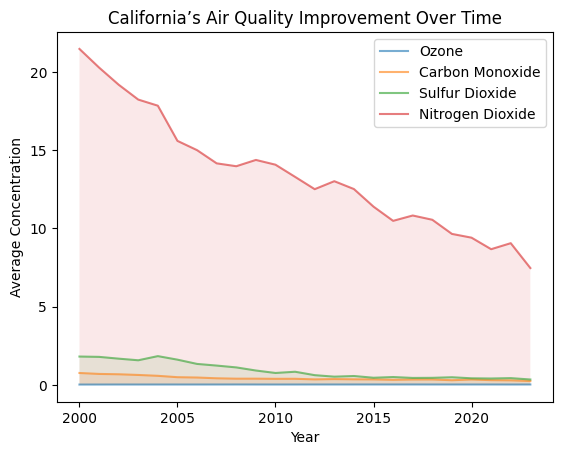

In [31]:
state_df = visualization_df.groupby(['State', 'State_Abbre', 'Year',])\
[['Ozone',	'Ozone AQI',	'Carbon Monoxide',	'Carbon Monoxide AQI',	'Sulfur Dioxide',	'Sulfur Dioxide AQI',	'Nitrogen Dioxide',	'Nitrogen Dioxide AQI']].mean().reset_index()
#state_df.head()

stateCA_df = state_df[state_df['State'] == 'California']

# Plot 
stateCA_df.plot(x='Year', y=['Ozone', 'Carbon Monoxide', 'Sulfur Dioxide', 'Nitrogen Dioxide'], kind='line', alpha=0.6)
plt.fill_between(stateCA_df['Year'], stateCA_df['Ozone'], alpha=0.1)
plt.fill_between(stateCA_df['Year'], stateCA_df['Carbon Monoxide'], alpha=0.1)
plt.fill_between(stateCA_df['Year'], stateCA_df['Sulfur Dioxide'], alpha=0.1)
plt.fill_between(stateCA_df['Year'], stateCA_df['Nitrogen Dioxide'], alpha=0.1)
plt.title('California’s Air Quality Improvement Over Time')
plt.xlabel('Year')
plt.ylabel('Average Concentration')
plt.show()

In [32]:
state_df.to_excel('output/state_.xlsx')

# Correlation Matrix Explanation

This heatmap represents the correlation between various air pollutants, specifically Ozone, Carbon Monoxide, 
Sulfur Dioxide, and Nitrogen Dioxide. Correlation values range from -1 to 1, where:
- 1 indicates a perfect positive correlation, meaning as one pollutant increases, the other increases.
- -1 indicates a perfect negative correlation, meaning as one pollutant increases, the other decreases.
- 0 indicates no correlation between the pollutants.

Key observations:
- Ozone shows a moderate negative correlation with Carbon Monoxide (-0.37) and Nitrogen Dioxide (-0.38), suggesting that these pollutants tend to decrease as Ozone levels increase.
- Carbon Monoxide is positively correlated with Sulfur Dioxide (0.22) and Nitrogen Dioxide (0.67), indicating that these pollutants tend to increase together.
- Sulfur Dioxide also has a moderate positive correlation with Nitrogen Dioxide (0.42).

These correlations suggest potential common sources or atmospheric interactions between the pollutants.

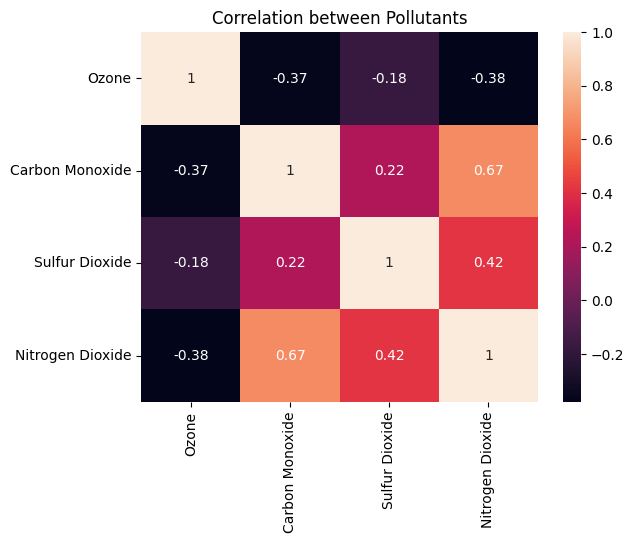

In [33]:
sns.heatmap(visualization_df[['Ozone',	'Carbon Monoxide',	'Sulfur Dioxide',	'Nitrogen Dioxide']].corr(), annot=True)
plt.title('Correlation between Pollutants')
plt.show()

# Folium Map Explanation

This code generates an interactive map using Folium to visualize Nitrogen Dioxide (NO2) levels across the United States.

- For each location in the dataset (`visualization_df`), a circle is added to the map. These circles represent the concentration of NO2 at specific geographical coordinates.
- The size of each circle is proportional to the `Nitrogen Dioxide` values in the dataset, with larger circles indicating higher concentrations of NO2. 



In [34]:
# Criar um mapa básico centrado nos EUA
map_NO2 = folium.Map(location=[37.8, -96], zoom_start=4)

# Adicionar círculos com base nos valores de NO2 Mean
for _, row in visualization_df.iterrows():
    folium.Circle(
        location=[row['Latitude'], row['Longitude']],  # Você precisa de coordenadas
        radius=row['Nitrogen Dioxide'] * 1000,  # Ajustar o tamanho do círculo
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(map_NO2)

# Mostrar o mapa
map_NO2